# CPE-221 Mini-Project: Laptop Price Prediction
- Dataset: Kaggle Laptop Price
- Authors: iamkuyik, Joseph Prince Aniekeme

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
!pip install missingno
import re
import missingno as msno  # nice package for visualizing missing values


In [2]:
# Setting seaborn style for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [3]:
df = pd.read_csv('../data/raw/laptop_price.csv', encoding='latin1')
print(df.shape)
df.head()

(1303, 13)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## 2. Understand Dataset & Check Data Types

In [4]:
import sys
print(sys.executable)


/home/prince/Laptop_price_prediction_model/.venv/bin/python


In [5]:
import re, pandas as pd, numpy as np
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [6]:
# Let's check the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [7]:
# Summary statistics for numeric columns
df.describe(include=[np.number])

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [8]:
# Let's quickly peek into categorical columns to see what values they hold
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn: {col}")
    print(df[col].unique()[:10])  # showing just first 10 unique values for readability

# *This helps us identify data types, potential issues (like numbers stored as strings), and gives a sense of categories.*


Column: Company
['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba']

Column: Product
['MacBook Pro' 'Macbook Air' '250 G6' 'Aspire 3' 'ZenBook UX430UN'
 'Swift 3' 'Inspiron 3567' 'MacBook 12"' 'IdeaPad 320-15IKB' 'XPS 13']

Column: TypeName
['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']

Column: ScreenResolution
['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / Touchscreen 1920x1080'
 'Full HD / Touchscreen 1920x1080' 'Touchscreen / Quad HD+ 3200x1800']

Column: Cpu
['Intel Core i5 2.3GHz' 'Intel Core i5 1.8GHz'
 'Intel Core i5 7200U 2.5GHz' 'Intel Core i7 2.7GHz'
 'Intel Core i5 3.1GHz' 'AMD A9-Series 9420 3GHz' 'Intel Core i7 2.2GHz'
 'Intel Core i7 8550U 1.8GHz' 'Intel Core i5 8250U 1.6GHz'
 'Intel Core i3 6006U 2GHz']

Column: Ram
['8GB' '16GB' '4GB' '2GB' '12GB' 

## 3. Handle Missing Values

In [9]:
# Check for missing values across all columns
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64


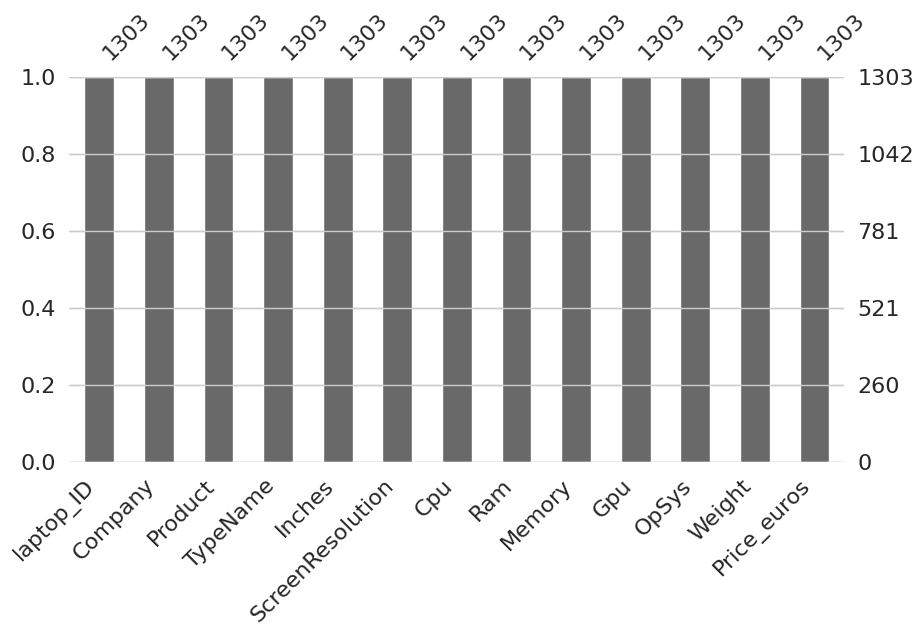

In [10]:
# Visualize missing values with a bar chart
msno.bar(df, figsize=(10,5))
plt.show()

In [11]:
# Strategy for missing values:
# - Drop columns with too many missing values (>40% missing)
# - Fill missing categorical values with the most frequent value (mode)
# - Fill missing numeric values with the median (robust to outliers)

threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)  # drop columns with too many NaNs

for col in df.columns:
    if df[col].isna().sum() > 0:  # if column still has missing values
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)  # fill with most common category
        else:
            df[col].fillna(df[col].median(), inplace=True)   # fill numeric with median

print("Remaining missing values:", df.isna().sum().sum())

Remaining missing values: 0


## 4. Remove Duplicates

In [12]:
# Duplicates can skew analysis and models, so let's remove them
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


## 5. Convert Columns to Proper Types

In [13]:
# Function to extract numeric values from strings (useful for RAM/Storage)
def extract_numeric(text):
    if pd.isna(text):
        return np.nan
    # use regex to capture number (with optional decimal)
    m = re.search(r'(\d+(?:\.\d+)?)', str(text))
    if not m:
        return np.nan
    val = float(m.group(1))
    # If the string contains TB, convert to GB for consistency
    if 'TB' in str(text):
        val *= 1000
    return val

In [14]:
# Convert RAM to GB
if 'Ram' in df.columns:
    df['Ram_GB'] = df['Ram'].apply(extract_numeric).astype(float)

# Convert Memory to GB
if 'Memory' in df.columns:
    df['Memory_GB'] = df['Memory'].apply(extract_numeric).astype(float)

# Ensure Price is numeric
if 'Price_euros' in df.columns:
    df['Price_euros'] = pd.to_numeric(df['Price_euros'], errors='coerce')

## 6. Standardize Categories

In [15]:
# Many companies may appear only once or twice - group rare ones as 'Other'
if 'Company' in df.columns:
    top10 = df['Company'].value_counts().nlargest(10).index
    df['Company_std'] = df['Company'].where(df['Company'].isin(top10), 'Other')

# Drop the 'Product' column since it has too many unique values (high cardinality)
if 'Product' in df.columns:
    df.drop(columns=['Product'], inplace=True)

# Operating System standardization: unify categories to reduce noise
if 'OpSys' in df.columns:
    df['OpSys_std'] = df['OpSys'].replace({
        'Windows 10': 'Windows',
        'Windows 7': 'Windows',
        'macOS': 'Mac',
        'Mac OS X': 'Mac',
        'Linux': 'Linux',
        'No OS': 'Other',
        'Chrome OS': 'Other'
    })


## 7. Handle Outliers

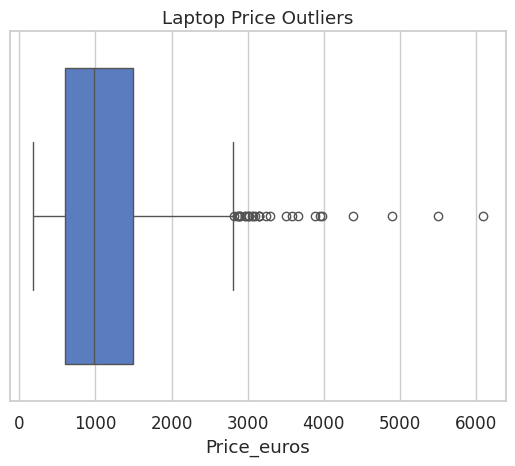

In [16]:
# Let's visualize laptop prices with a boxplot to spot outliers
sns.boxplot(x=df['Price_euros'])
plt.title('Laptop Price Outliers')
plt.show()


In [17]:
# A simple method: clip prices to the 1st and 99th percentiles
if 'Price_euros' in df.columns:
    lower, upper = df['Price_euros'].quantile([0.01, 0.99])
    df['Price_euros'] = df['Price_euros'].clip(lower, upper)


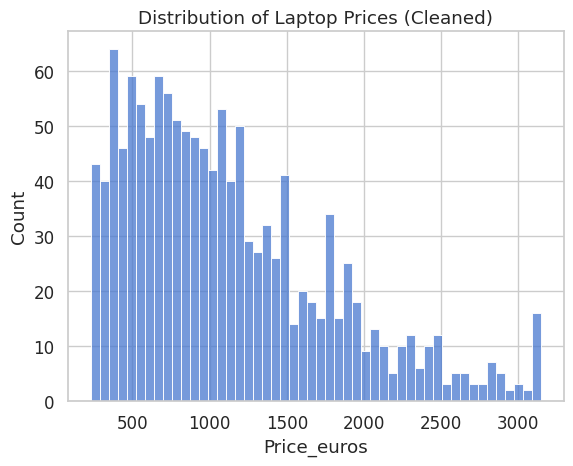

In [18]:
# Check distribution after clipping
sns.histplot(df['Price_euros'], bins=50)
plt.title('Distribution of Laptop Prices (Cleaned)')
plt.show()

## 8. Save Cleaned Dataset

In [19]:
# Save the cleaned dataset for further analysis or modeling
output_path = '../data/processed/laptop_price_clean.csv'
df.to_csv(output_path, index=False)

print(" Cleaned dataset saved to:", output_path)
print("Final shape:", df.shape)

 Cleaned dataset saved to: ../data/processed/laptop_price_clean.csv
Final shape: (1303, 16)


In [20]:
'''
##  Final Notes
- The dataset is now **clean, consistent, and ready for analysis**.  
- We addressed missing values, removed duplicates, converted columns, and standardized categories.  
- Outliers were clipped to reduce noise in modeling.  
- A cleaned version of the dataset was saved for reuse.  

 Next step: **Exploratory Data Analysis (EDA)** to identify relationships between features and laptop prices.
'''

'\n##  Final Notes\n- The dataset is now **clean, consistent, and ready for analysis**.  \n- We addressed missing values, removed duplicates, converted columns, and standardized categories.  \n- Outliers were clipped to reduce noise in modeling.  \n- A cleaned version of the dataset was saved for reuse.  \n\n Next step: **Exploratory Data Analysis (EDA)** to identify relationships between features and laptop prices.\n'